In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
plv_hist = np.genfromtxt ('plv_hist.csv', delimiter=",")
plv_pi = np.genfromtxt ('plv_pi.csv', delimiter=",")
volc_sigl = -1*np.genfromtxt ('sigl.txt', delimiter=",")
volc_source_sigl = np.genfromtxt ('volc_source_850_1849.csv', delimiter=",")
# data source https://media.nature.com/original/nature-assets/nature/journal/v523/n7562/extref/nature14565-s6.xlsx
# from the paper https://www.nature.com/articles/nature14565
# Other data for phase coherence taken from PMIP3 simulations of IPSL model

# The PI control experiment data is from 850-1849 and the historical last millenium 
# run is from 850-1850, hence there is one year extra in the historical run. So we need to 
# take only upto 1849 to have complete 1000 years. Further the phase locking values are 
# calculated as from 3 year moving windows. So, the first value represents July 1851 and the 
# last value represents June 1848, Hence there are 11964 months. From the yearly volcanic 
# data a monthly dataset is created in which the first six months have the values of 
# volcanic year 1851 and the last six months have the values of the year 1848
# sigl.txt also has data from 850-1850 hence the last year is discarded
#
# Making monthly dataset for volcanic forcing corresponding to the phase locking values
# 0:1000 is the index of volc_sigl in python, hence 1000 corresponds to 1850
# 999 corresponds to 1849 and 998 corresponds to 1848, since the phase coherence analysis
# has been done for a period of 1000 years and a 3 year moving window is used for calculating 
# plv values, the plv time series will have a size 997*12

volc_data = volc_sigl[1:998]

# in volc_source_sigl indices 0 and 999 represent 850 and 1849, 0:999 will give 0:998 
# in reality, 1 represents 851 and 998 represents 1848
volc_source_data = volc_source_sigl[1:999]

volc_data_mon = np.zeros((997*12))
volc_source_data_mon = np.zeros((997*12))

volc_data_mon[0:6] = volc_data[0]
volc_source_data_mon[0:6] = volc_source_data[0]

volc_data_mon[11958:11964] = volc_data[-1]
volc_source_data_mon[11958:11964] = volc_source_data[-1]

for yyyy in range(996):
    volc_data_mon[6+yyyy*12:18+yyyy*12] = volc_data[1+yyyy]
    volc_source_data_mon[6+yyyy*12:18+yyyy*12] = volc_source_data[1+yyyy]
print(volc_source_data[0:10])
print(volc_source_data_mon[0:120])

# Creating a 2D array plv whose first column will contain plv for PI and the second column 
# will contain the plv for historical

plv = np.zeros((plv_pi.shape[0], 2))
plv[:,0] = plv_pi[:]
plv[:,1] = plv_hist[0:11964]

thres = 0.95

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


22.8146
[ 16.  28.  20. ...,  29.  22.  30.]


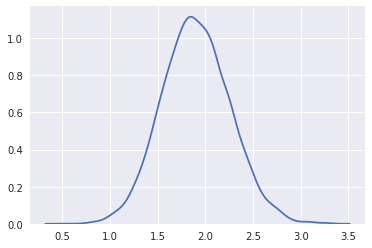

In [2]:
# 10 year PI control not considering first 200 years
import random
Nsample = plv[1200:,1].shape[0]
N=10000
thres = 0.95
dummy_log = np.zeros((120))
dummy_log_sum = 0
plv_pi_monte_carlo = np.zeros((Nsample))
plv_pi_monte_carlo[0:Nsample] = plv[1200:,0]
dummy_pi_scatter = np.zeros((N))

for niter in range(N):
    dummy = plv_pi_monte_carlo[random.sample(range(0, 8399), 120)]
    dummy_log[dummy<thres] = 0
    dummy_log[dummy>thres] = 1
    dummy_log_sum = dummy_log_sum + np.sum(dummy_log)
    dummy_pi_scatter[niter] = np.sum(dummy_log)
print(dummy_log_sum/N)
print(dummy_pi_scatter)
sns.kdeplot(dummy_pi_scatter/12)
#plt.savefig('plv_pi_pdf.eps', format='eps', dpi=1000)

22.121
9.11


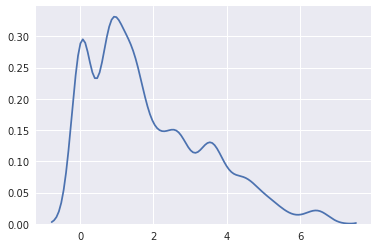

In [3]:
# 10 year historical only volcanic PLV volc thres = 10 for extra-tropical eruptions
import random
import warnings
warnings.filterwarnings('ignore')
Nsample = plv[:,1].shape[0]
N=10000
thres = 0.95
dummy_log = np.zeros((120))

dummy_log_sum = 0
plv_hist_monte_carlo = np.zeros((Nsample))
plv_hist_monte_carlo = plv[:,1]
niter = 0
dummy_hist_scatter = np.zeros((N))
while niter < N:
    rand_year = random.sample(range(10, 11830), 1)
    #print(rand_year[0])
    dummy = plv_pi_monte_carlo[rand_year[0]:rand_year[0]+120]
    dummy_1 = dummy
    if np.max(volc_data_mon[rand_year[0]:rand_year[0]+120]) < 0.1:
        continue
    if np.max(volc_source_data_mon[rand_year[0]:rand_year[0]+120]) < 1.1:
        continue
    dummy_hist_scatter[niter] = np.sum(dummy_log)
    niter = niter + 1
    dummy_log[dummy_1<thres] = 0
    dummy_log[dummy_1>thres] = 1
    #print(niter)
    dummy_log_sum = dummy_log_sum + np.sum(dummy_log)
    
print(dummy_log_sum/N)
print(np.sum(volc_data[800:850])-10.24)
#print(volc_data[800:850]) # include later
#print(dummy_hist_scatter_1650_1700[1100:1200])
#1650-1700
sns.kdeplot(dummy_hist_scatter[:]/12)

In [4]:
# Performing 2 sampled Kolmogrov Smirnov test from 
# https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html
from scipy import stats
stats.ks_2samp(dummy_pi_scatter, dummy_hist_scatter)

Ks_2sampResult(statistic=0.4199, pvalue=0.0)